Complete notebook available at: https://github.com/ai4up/ufo-prediction/blob/main/demo/demo.ipynb

## Motivation

Building attributes such as building height, type, and construction year are not available for all buildings in EUBUCCO. However, for many prospective use cases of the dataset, such as energy modeling, the building attributes are of high importance. This notebook shows how the available building footprints can be used to estimate missing building attributes with supervised machine learning.

In [4]:
# -.-|m { input: false }

!pip install -r ../requirements.txt


  Using cached haversine-2.5.1-py2.py3-none-any.whl (6.1 kB)


In [2]:
# -.-|m { input: false }

# standard libs
import os
import sys
import logging

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison
import preprocessing as pp

# external libs
import numpy as np
import pandas as pd
import geopandas as gpd
from xgboost import XGBRegressor, XGBClassifier

In [3]:
# -.-|m { input: false }

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

## Data

Demo sample of ~20k buildings for Spain, ~50k for France, and 170k for the Netherlands. All 117 urban form features, lat lon, as well as some auxiliary attributes like city name, neighborhood, building type, etc. are included.

The demo samples are stored using Git Large File Storage (LFS). To download them explicitly use:

In [23]:
!git lfs pull

In [27]:
DATA_DIR = '.'

path_data_NLD = os.path.join(DATA_DIR, 'df-NLD-exp.pkl')
path_data_FRA = os.path.join(DATA_DIR, 'df-FRA-exp.pkl')
path_data_ESP = os.path.join(DATA_DIR, 'df-ESP-exp.pkl')

df = pd.read_pickle(path_data_FRA)


In [5]:
df.tail()


source_file  dist_to_closest_int  \
343 9464158  NL_lod12_2d_pand_2            28.325185   
    9464159  NL_lod12_2d_pand_2            85.265836   
    9464160  NL_lod12_2d_pand_2            79.767405   
    9464161  NL_lod12_2d_pand_2           235.244702   
    9464162  NL_lod12_2d_pand_2             7.041649   

             av_footprint_area_within_buffer_100  \
343 9464158                           104.216922   
    9464159                           144.168320   
    9464160                           152.116514   
    9464161                           160.043628   
    9464162                          2081.186275   

             street_betweeness_global_max_within_buffer_500  \
343 9464158                                        0.177374   
    9464159                                        0.173235   
    9464160                                        0.083670   
    9464161                                        0.054504   
    9464162                                        0.137790   

             av_elongation_within_buffer_500                         geometry  \
343 9464158                         0.667979  POINT (4036486.156 3136243.008)   
    9464159                         0.686321  POINT (4037024.064 3136344.553)   
    9464160                         0.652507  POINT (4038870.680 3136864.611)   
    9464161                         0.617475  POINT (4039587.215 3136875.322)   
    9464162                         0.638787  POINT (4035561.590 3139022.261)   

             std_building_footprint_city     block  blocks_2_to_4  \
343 9464158                   693.064008  aabf87da          648.0   
    9464159                   693.064008  c78ab41f          648.0   
    9464160                   693.064008  035639ac          648.0   
    9464161                   693.064008  9fa32752          648.0   
    9464162                   693.064008  738849ea          648.0   

             street_closeness_500_av_within_buffer_500  ...  \
343 9464158                                   0.000131  ...   
    9464159                                   0.000092  ...   
    9464160                                   0.000016  ...   
    9464161                                   0.000012  ...   
    9464162                                   0.000015  ...   

             buildings_within_buffer_100  \
343 9464158                         93.0   
    9464159                         30.0   
    9464160                         20.0   
    9464161                          7.0   
    9464162                          9.0   

             street_betweeness_global_max_within_buffer_100  \
343 9464158                                        0.058791   
    9464159                                        0.067751   
    9464160                                        0.014295   
    9464161                                        0.008389   
    9464162                                        0.001681   

                       TouchesIndexes  \
343 9464158  [3840, 5469, 5783, 5440]   
    9464159                    [5784]   
    9464160              [2995, 5785]   
    9464161                    [5786]   
    9464162                    [5787]   

             street_based_block_av_phi_inter_buffer_500  \
343 9464158                                    0.302208   
    9464159                                    0.399677   
    9464160                                    0.399282   
    9464161                                    0.439683   
    9464162                                    0.411613   

             total_length_street_city  total_buildings_footprint_city  \
343 9464158             302292.366875                    1.108602e+06   
    9464159             302292.366875                    1.108602e+06   
    9464160             302292.366875                    1.108602e+06   
    9464161             302292.366875                    1.108602e+06   
    9464162             302292.366875                    1.108602e+06   

                  Phi  st

Get more data from EUBUCCO

In [29]:
import requests
import urllib.parse

root_url = "https://api.eubucco.com"
api_url = "/v0.1/countries"

#print(urllib.parse.urljoin(root_url, api_url))

response = requests.get(urllib.parse.urljoin(root_url, api_url))
response.json()

# parsing json blablabla



[{'id': 29,
  'name': 'Czechia Other-license',
  'convex_hull': None,
  'csv': {'id': 'a28f2c93-0c50-4d22-95ef-e2f40725683c',
   'name': 'v0_1-CZE_11-OTHER-LICENSE-CC-BY-SA.csv.zip',
   'size_in_mb': 2.2867984771728516,
   'type': 'BU',
   'download_link': 'https://api.eubucco.com/v0.1/files/a28f2c93-0c50-4d22-95ef-e2f40725683c/download',
   'info': ''},
  'gpkg': {'id': 'd044e347-7106-4516-811e-b340deac2041',
   'name': 'v0_1-CZE_11-OTHER-LICENSE-CC-BY-SA.gpkg.zip',
   'size_in_mb': 86.58027458190918,
   'type': 'BU',
   'download_link': 'https://api.eubucco.com/v0.1/files/d044e347-7106-4516-811e-b340deac2041/download',
   'info': ''}},
 {'id': 30,
  'name': 'Italy Other-license',
  'convex_hull': None,
  'csv': {'id': '23da4eb0-7e61-4d47-b104-e2a1f2e1388e',
   'name': 'v0_1-ITA_1-OTHER-LICENSE-CC-BY-NC.csv.zip',
   'size_in_mb': 3.1801042556762695,
   'type': 'BU',
   'download_link': 'https://api.eubucco.com/v0.1/files/23da4eb0-7e61-4d47-b104-e2a1f2e1388e/download',
   'info': ''},


In [34]:
gpd.read_file("C:/Users/utente/ufo-prediction/metadata/v0_1-CYP.gpkg/v0_1-CYP.gpkg")

KeyboardInterrupt: 

## Prediction

In [18]:
xgb_model_params = {'tree_method': 'hist'}
xgb_hyperparams = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

### Regression

2024-01-16 16:47:30,369 | INFO : Dataset length: 49266
2024-01-16 16:47:30,420 | INFO : Dataset allocated memory: 52 MB
2024-01-16 16:47:30,768 | INFO : No abort signal received. Continuing... To abort please create C:\Users\utente\ufo-prediction\metadata\local-f5abb725.abort.
2024-01-16 16:47:30,774 | INFO : Dataset standard deviation: 64.31994496479933
2024-01-16 16:47:30,774 | INFO : Dataset mean age: 1950.0572808833679
2024-01-16 16:47:30,782 | INFO : Training dataset length: 39412
2024-01-16 16:47:30,782 | INFO : Test dataset length: 9854
2024-01-16 16:47:31,350 | INFO : Test dataset standard deviation after preprocessing: 26.210160526077786
2024-01-16 16:47:31,353 | INFO : Test dataset mean age after preprocessing: 1978.1880906148867
2024-01-16 16:47:31,355 | INFO : Training dataset length after preprocessing: 31011
2024-01-16 16:47:31,358 | INFO : Test dataset length after preprocessing: 7725
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Us

MAE: 13.96 y
RMSE: 19.48 y
R2: 0.4476


2024-01-16 16:48:02,300 | INFO : binning continuous age (regression)
2024-01-16 16:48:02,581 | ERROR : Failed to calculate energy error: can only concatenate str (not "tuple") to str
2024-01-16 16:48:02,742 | INFO : (7725, 1, 7725, 1)


R2: nan
MAPE: nan


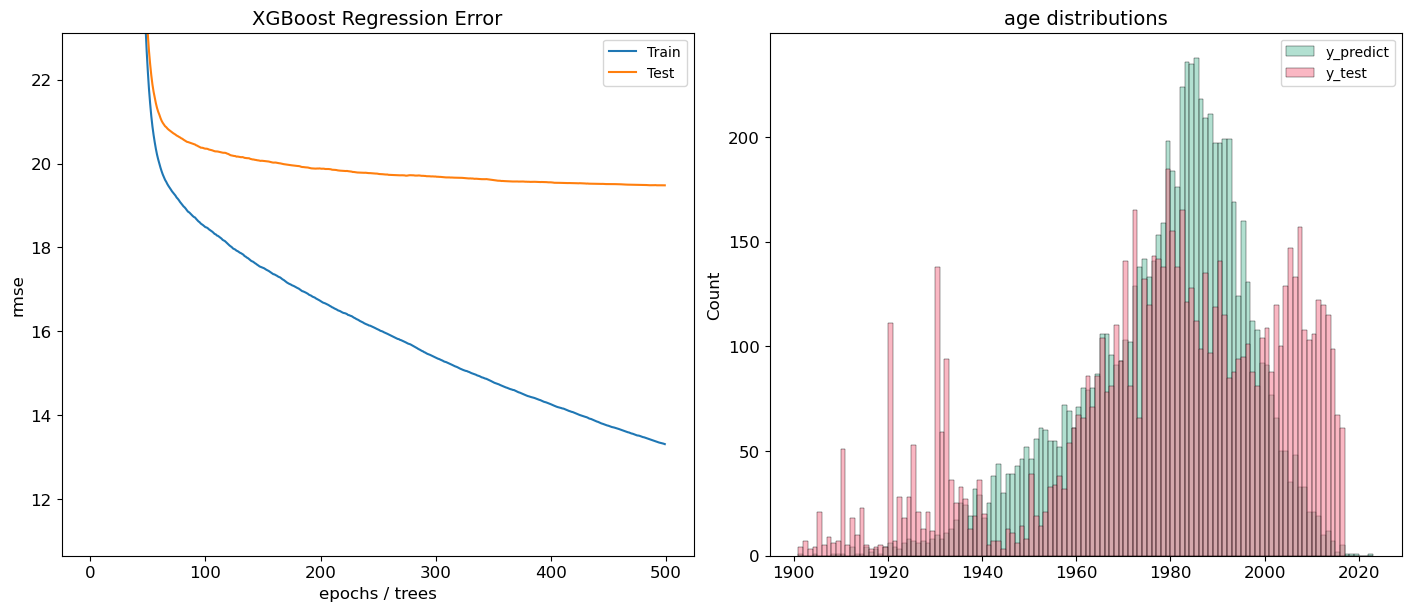

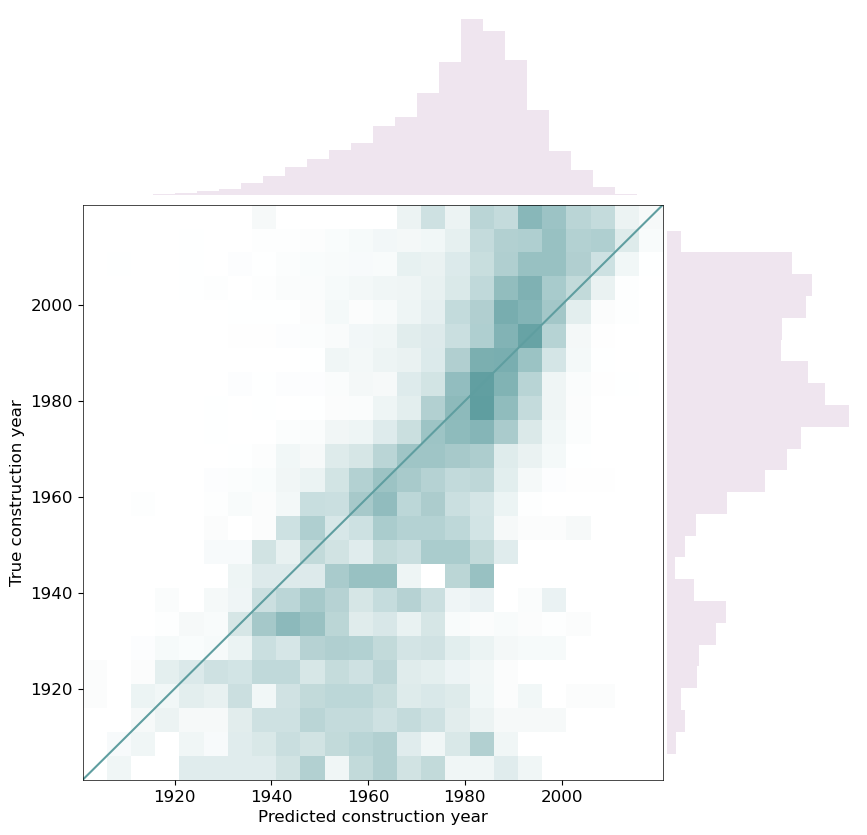

In [24]:
predictor = AgePredictor(
    model=XGBRegressor(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    early_stopping=True,
    hyperparameters=xgb_hyperparams,
    preprocessing_stages=[pp.remove_outliers]
)

predictor.evaluate()


### Classification

2024-01-16 16:38:50,441 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2024-01-16 16:38:50,446 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']
2024-01-16 16:38:50,650 | INFO : Dataset length: 49266
2024-01-16 16:38:50,683 | INFO : Dataset allocated memory: 52 MB
2024-01-16 16:38:50,862 | INFO : No abort signal received. Continuing... To abort please create C:\Users\utente\ufo-prediction\metadata\local-e5565226.abort.
2024-01-16 16:38:50,862 | INFO : Training dataset length: 39412
2024-01-16 16:38:50,869 | INFO : Test dataset length: 9854
2024-01-16 16:38:50,875 | INFO : Test cities: ['Montauban' 'Royat' 'Saint-Ciers-sur-Gironde' "L'Île-d'Yeu" 'Lescar'
 'Arleux' 'Mortrée' 'Niolu-Omessa' 'Oullins' 'Ribiers']
2024-01-16 16:38:51,163 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2024-01-16 16:38:51,326 | INFO : age attribute has been 

Classification report:
               precision    recall  f1-score  support
1900-1964      0.665005  0.740700  0.700814     1801
1965-1974      0.466355  0.474786  0.470533     1051
1975-1991      0.678646  0.578340  0.624491     2253
1992-2005      0.537809  0.532540  0.535162     1429
2006-2014      0.521847  0.595484  0.556239     1063
2015-2021      0.356436  0.281250  0.314410      128
accuracy       0.591068  0.591068  0.591068        0
macro avg      0.537683  0.533850  0.533608     7725
weighted avg   0.593615  0.591068  0.590284     7725
Cohen’s kappa: 0.4839
Matthews correlation coefficient (MCC): 0.4849


FixedFormatter should only be used together with FixedLocator


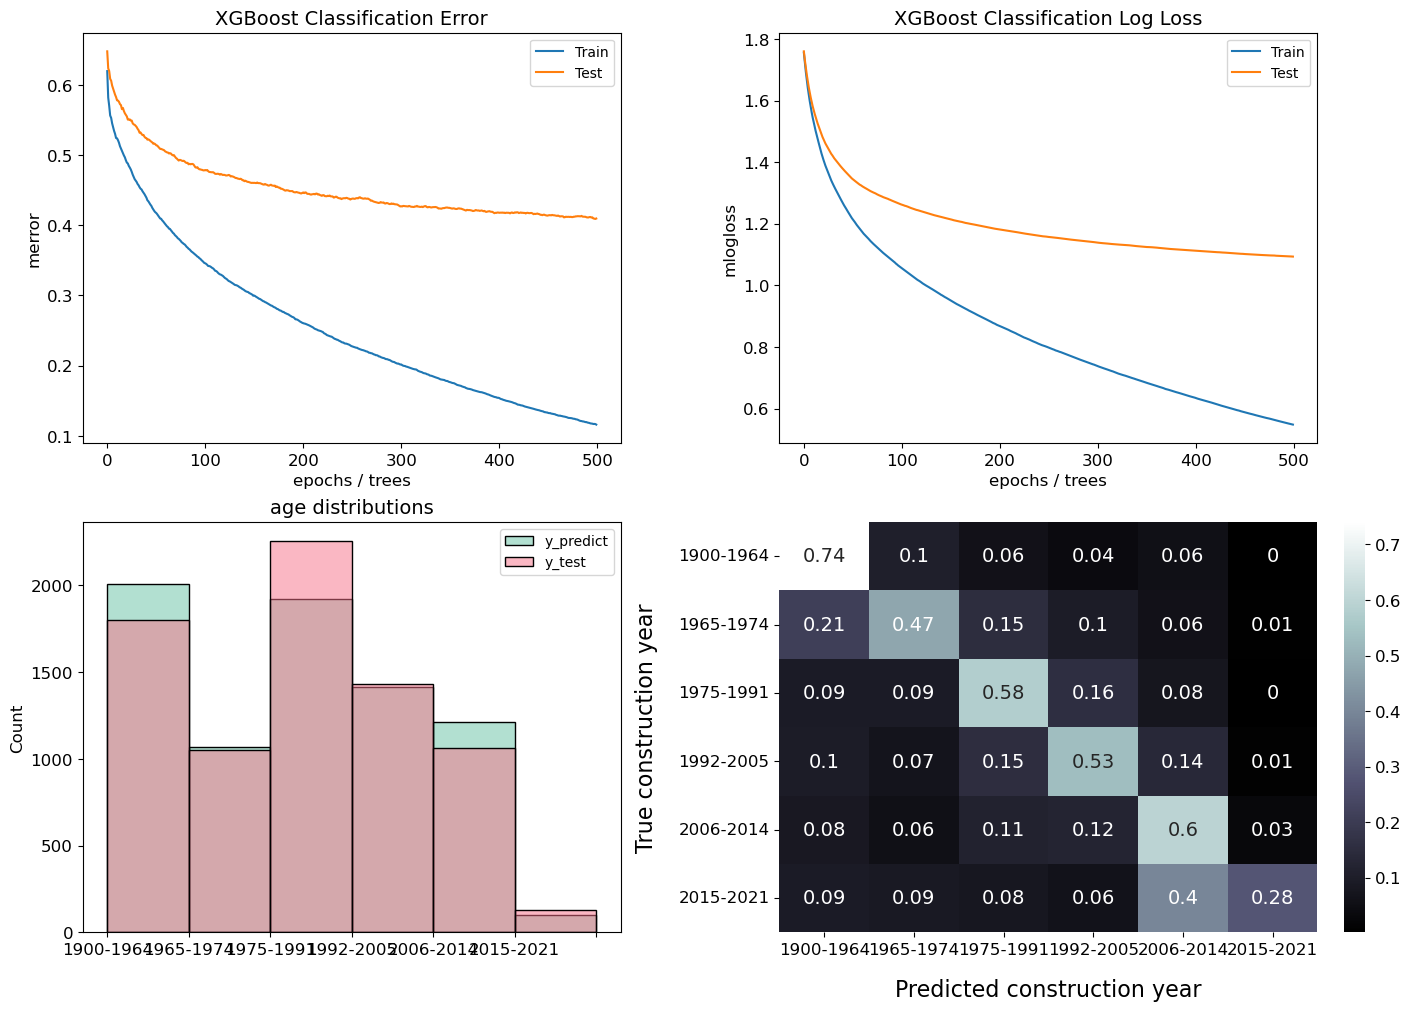

In [20]:
tabula_nl_bins = [1900, 1965, 1975, 1992, 2006, 2015, 2022]
equally_sized_bins = (1900, 2020, 10)

classifier = AgeClassifier(
    model=XGBClassifier(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    mitigate_class_imbalance=True,
    # bin_config=equally_sized_bins,
    bins=tabula_nl_bins,
)
classifier.evaluate()

### Country and generalization comparison

The `AgePredictorComparison` faciliates comparisons between differently configured training runs, for example to compare the prediction performance between countries, cross-validation strategies, oversampling strategies or any other preprocessing steps.

In [34]:
comparison_config = {
    'Spain': {'df': path_data_ESP},
    'France': {'df': path_data_FRA},
    'Netherlands': {'df': path_data_NLD},
}

grid_comparison_config = {
    'random-cv': {'cross_validation_split': pp.cross_validation},
    'neighborhood-cv': {'cross_validation_split': pp.neighborhood_cross_validation},
    'city-cv': {'cross_validation_split': pp.city_cross_validation},
}

comparison = AgePredictorComparison(
    exp_name='demo',
    model=XGBRegressor(**xgb_model_params),
    df=None,
    frac=0.5,
    cross_validation_split=None,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    compare_feature_importance=False,
    compare_classification_error=False,
    include_baseline=False,
    save_results=False,
    garbage_collect_after_training=True,
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)

results = comparison.evaluate()

2022-10-21 16:42:52,510 | INFO : Starting experiment Spain_random-cv...
2022-10-21 16:42:53,720 | INFO : Dataset length: 974
2022-10-21 16:42:53,726 | INFO : Dataset allocated memory: 1 MB
2022-10-21 16:42:53,731 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs/local-1eb3cae2.abort.
2022-10-21 16:42:53,731 | INFO : Dataset standard deviation: 45.78138305502198
2022-10-21 16:42:53,732 | INFO : Dataset mean age: 1950.3613963039015
2022-10-21 16:42:53,733 | INFO : Training dataset length: 779
2022-10-21 16:42:53,733 | INFO : Test dataset length: 195
2022-10-21 16:42:53,748 | INFO : Test dataset standard deviation after preprocessing: 34.49407581359104
2022-10-21 16:42:53,749 | INFO : Test dataset mean age after preprocessing: 1958.8352272727273
2022-10-21 16:42:53,749 | INFO : Training dataset length after preprocessing: 710
2022-10-21 16:42:53,749 | INFO : Test dataset length after preprocessing: 176
`early_stopping_rounds` in `

In [35]:
results

,name,R2,R2_std,MAE,MAE_std,RMSE,RMSE_std,within_5_years,within_10_years,within_20_years,R2_seed_0
8,Netherlands_city-cv,0.135401,0.0,18.030643,0.0,23.598668,0.0,0.221385,0.392977,0.638903,0.135401
7,France_city-cv,0.187767,0.0,18.645831,0.0,23.772030,0.0,0.176875,0.345911,0.615315,0.187767
6,Spain_city-cv,0.197072,0.0,23.840955,0.0,29.563272,0.0,0.126411,0.247178,0.494357,0.197072
3,Spain_neighborhood-cv,0.198503,0.0,23.779078,0.0,29.536916,0.0,0.129797,0.247178,0.506772,0.198503
5,Netherlands_neighborhood-cv,0.304538,0.0,15.884060,0.0,21.164937,0.0,0.241489,0.444702,0.699700,0.304538
4,France_neighborhood-cv,0.330228,0.0,16.306574,0.0,21.586864,0.0,0.211348,0.408337,0.705209,0.330228
0,Spain_random-cv,0.363164,0.0,20.108252,0.0,26.328608,0.0,0.180587,0.355530,0.592551,0.363164
1,France_random-cv,0.511105,0.0,12.372172,0.0,18.443089,0.0,0.369564,0.593466,0.806340,0.511105
2,Netherlands_random-cv,0.575725,0.0,10.203823,0.0,16.531180,0.0,0.525335,0.695626,0.827052,0.575725
